## Este codigo es para el diseno de ataques

### Librerías necesarias

In [106]:
from os.path import join
from matplotlib.image import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf

# Definición de rutas

In [107]:
data_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals'
models_path = 'models'
train_data_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals\Train'
labels_path = 'D:\MaIE\Semestre3\RL\Data\TrafficSignals\Test.csv'

### Cargar imágenes de testeo

In [108]:
data = []
labels = []
Table = pd.read_csv(labels_path)
Table['Path']
for j in range(0,Table['Path'].shape[0]):
    ima_path =join(data_path, Table['Path'][j])
    imagen = imread(ima_path,-1)
    imagen = resize(imagen,(32,32))
    data.append(imagen)
    labels.append(Table['ClassId'][j])

In [109]:
data2 = np.array(data)
labels2 = np.array(labels)
print(data2.shape,labels2.shape)

(12630, 32, 32, 3) (12630,)


In [110]:
X_test = data2
y_test = labels2

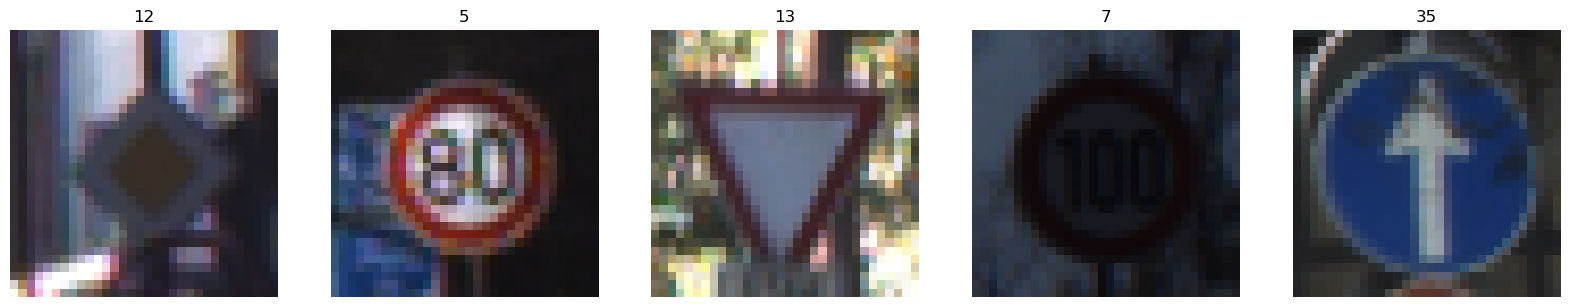

In [111]:
test_images = [X_test[10], X_test[30], X_test[26], X_test[40],  X_test[9]]
test_labels = [y_test[10], y_test[30], y_test[26], y_test[40], y_test[9]]
plt.figure(figsize=(20, 10))
for i in range(5):
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(test_images[i])
      plt.title(test_labels[i])
      plt.axis("off")

In [112]:
class AttackModel():
    def __init__(self, model, images, epsilons):
        self.model = model
        self.images = images
        self.epsilons = epsilons
        
    def predict(self, image):
        ref = np.argmax(self.model(image))
        return tf.constant(to_categorical(ref, 43).reshape(1, 43))
    
    def get_adversarial_image(self, image, epsilon, target=None):
        image = tf.cast(image.reshape(1, 32, 32, 3), tf.float32)
        if target is None:
            label = self.predict(image)
        else:
            label = tf.constant(to_categorical(target, 43).reshape(1, 43))
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.model(image)
            loss = CategoricalCrossentropy()(label, prediction)
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        disturbance = signed_grad[0] * 0.5 + 0.5 
        adversarial_image = (image + epsilon * signed_grad) if target is None else (image - epsilon * signed_grad)
        y_disturbance = np.argmax(self.model(adversarial_image))
        return adversarial_image, y_disturbance, disturbance
    
    def get_adversarial_images(self, targets=None):
        adv_images = []
        adv_labels = []
        adv_disturbances = []
        for i in range(len(self.images)):
            adv_image, adv_label, adv_disturbance = self.get_adversarial_image(
                self.images[i], self.epsilons[i], targets[i] if targets else None)
            adv_images.append(adv_image)
            adv_labels.append(adv_label)
            adv_disturbances.append(adv_disturbance)
        return np.array(adv_images), np.array(adv_labels), np.array(adv_disturbances)


In [135]:
class AttackModel10Pixels():
    def __init__(self, model, images, epsilons):
        self.model = model
        self.images = images
        self.epsilons = epsilons
        
    def predict(self, image):
        ref = np.argmax(self.model(image))
        return tf.constant(to_categorical(ref, 43).reshape(1, 43))
    
    def get_adversarial_image(self, image, epsilon, target=None):
        image = tf.cast(image.reshape(1, 32, 32, 3), tf.float32)
        if target is None:
            label = self.predict(image)
        else:
            label = tf.constant(to_categorical(target, 43).reshape(1, 43))
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.model(image)
            loss = CategoricalCrossentropy()(label, prediction)
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        disturbance = signed_grad[0] * 0.5 + 0.5 
        # Modify only 10 pixels
        pixels_to_perturb = np.random.choice(range(32*32), size=10, replace=False)
        perturbation = np.zeros((32, 32, 3))
        for p in pixels_to_perturb:
            x, y = p % 32, p // 32
            perturbation[x, y, :] = epsilon * signed_grad[0, x, y, :]
        adversarial_image = image + perturbation if target is None else image - perturbation
        y_disturbance = np.argmax(self.model(adversarial_image))
        return adversarial_image, y_disturbance, disturbance, perturbation
    
    def get_adversarial_images(self, targets=None):
        adv_images = []
        adv_labels = []
        adv_disturbances = []
        adv_perturbations = []
        for i in range(len(self.images)):
            adv_image, adv_label, adv_disturbance, perturbation = self.get_adversarial_image(
                self.images[i], self.epsilons[i], targets[i] if targets else None)
            adv_images.append(adv_image)
            adv_labels.append(adv_label)
            adv_disturbances.append(adv_disturbance)
            adv_perturbations.append(perturbation)
        return np.array(adv_images), np.array(adv_labels), np.array(adv_disturbances), np.array(adv_perturbations)


# Untargeted attack

## Modelo Andres-Ernesto

In [114]:
epsilons = [0.0058, 0.008, 0.013, 0.0009, 0.06]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[30  3 15  8 39]


## Modelo Donovan-Jorge

In [115]:
epsilons = [0.0032, 0.037, 0.034, 0.0058, 0.091]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[12  3 13  4 13]


# Target attack

## Modelo Andres-Ernesto

In [116]:
epsilons = [0.037, 0.044, 0.064, 0.015, 0.045]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)

[12, 5, 13, 7, 35]
[11  4 12  6 34]


## Modelo Donovan-Jorge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[11  4 12  6 34]


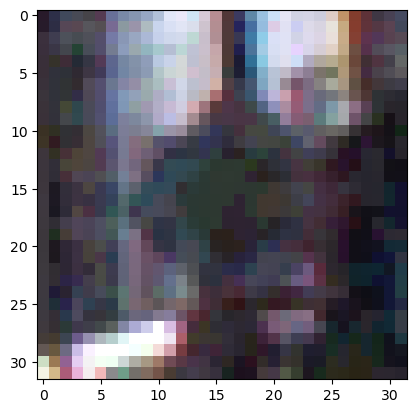

In [147]:
epsilons = [0.041, 0.03, 0.046, 0.011, 0.055]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)

## Modificar 10 pixeles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[13  5 13  7 35]


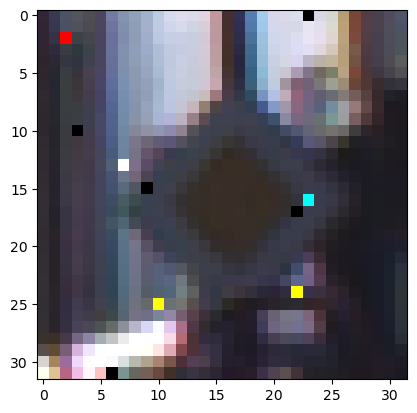

In [152]:
epsilons = [2, 0.044, 0.064, 0.015, 0.045]
attack_model = AttackModel10Pixels(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances, perturbations = attack_model.get_adversarial_images(targets)

print(test_labels)
print(adv_labels)
# plt.imshow(perturbations[0])
plt.figure()
plt.imshow(adv_images[0].reshape(32, 32, 3))